In [2]:
%pylab inline
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform
from jax.scipy.ndimage import map_coordinates
from constant import * 
import warnings
from jax import jit, partial
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [3]:
cgrid = np.load("cgrid.npy")
bgrid = np.load("bgrid.npy")
kgrid = np.load("kgrid.npy")
hgrid = np.load("hgrid.npy")

In [4]:
# define approximation of fit
def actions(w, n, s, e, t):
    c = map_coordinates(cgrid[:,:,:,:,t],np.vstack((w/scale,n/scale,s,e)), order = 1, mode = 'nearest')
    b = map_coordinates(bgrid[:,:,:,:,t],np.vstack((w/scale,n/scale,s,e)), order = 1, mode = 'nearest')
    k = map_coordinates(kgrid[:,:,:,:,t],np.vstack((w/scale,n/scale,s,e)), order = 1, mode = 'nearest')
    h = map_coordinates(hgrid[:,:,:,:,t],np.vstack((w/scale,n/scale,s,e)), order = 1, mode = 'nearest')
    return c,b,k,h
      
@jit    
def transition(b,k,s,s_next):
    return b*(1+r_b[s]) + k*(1+r_k[s_next])

#Define the earning function, which applies for both employment, 27 states
@partial(jit, static_argnums=(0,)) 
def y(t, x):
    if t <= T_R:
        return detEarning[t] * (1+gGDP[jnp.array(x[:,2], dtype = jnp.int8)]) * x[:,3] + (1-x[:,3]) * welfare
    else:
        return detEarning[t] * jnp.ones(X.shape[0])
    
#Earning after tax and fixed by transaction in and out from 401k account 
@partial(jit, static_argnums=(0,)) 
def yAT(t,x):
    yt = y(t, x)  
    if t <= T_R:
        # yi portion of the income will be put into the 401k if employed
        return (1-tau_L)*(yt * (1-yi))*x[:,3] + (1-x[:,3])*yt
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        return (1-tau_R)*yt + x[:,1]/Dt[t]
    
#Define the evolution of the amount in 401k account 
@partial(jit, static_argnums=(0,)) 
def gn(t, x, r):
    if t <= T_R:
        # if the person is employed, then yi portion of his income goes into 401k 
        n_cur = x[:,1] + y(t, x) * yi * x[:,3]
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        n_cur = x[:,1]  - x[:,1]/Dt[t]
        # the 401 grow as the same rate as the stock 
    return (1+r)*n_cur

In [7]:
import quantecon as qe
#number of economy
num = 500000
# markov chain used to generate economic states
mc = qe.MarkovChain(Ps)
econState = np.array([mc.simulate(ts_length=T_max - T_min, init=0) for _ in range(num)])

In [5]:
#initially with 5k wealth
w = np.ones(num)*5
n = np.zeros(num)
e = np.ones(num,dtype = int8)
ws = np.zeros((T_max-T_min,num))
ns = np.zeros((T_max-T_min,num))
cs = np.zeros((T_max-T_min,num))
bs = np.zeros((T_max-T_min,num))
ks = np.zeros((T_max-T_min,num))
hs = np.zeros((T_max-T_min,num))
for t in range(T_max-T_min-1):
    s = econState[:,t]
    s_next = econState[:,t+1]
    c,b,k,h = actions(w,n,s,t)
    ws[t,:] = w
    ns[t,:] = n
    cs[t,:] = c
    bs[t,:] = b
    ks[t,:] = k
    hs[t,:] = h
    w = transition(b,k,s,s_next)
    n = gn(t, s, s_next, n)

NameError: name 'num' is not defined

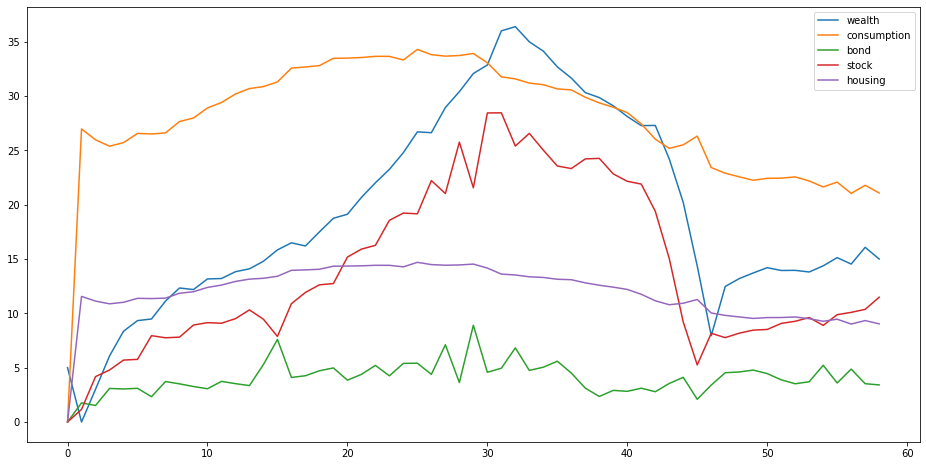

In [6]:
plt.figure(figsize = [16,8])
plt.plot(ws.mean(axis = 1)[:-1], label = "wealth")
plt.plot(cs.mean(axis = 1)[:-1], label = "consumption")
plt.plot(bs.mean(axis = 1)[:-1], label = "bond")
plt.plot(ks.mean(axis = 1)[:-1], label = "stock")
plt.plot((hs*pr).mean(axis = 1)[:-1], label = "housing")
plt.legend()

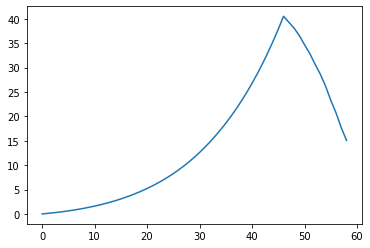

In [7]:
plt.plot(ns.mean(axis = 1)[:-1], label = "401k")

In [8]:
yi

0.002